## Todo

pipelines custom age \
roc_auc \
poly features? \
remove unnecessary 


## Data

In [1]:
import pandas as pd

from matplotlib import pyplot as plt
import pylab as plot
import logging


pd.options.display.max_columns = 100
log = logging.getLogger(__name__)

In [2]:
import argparse
args = argparse.Namespace()
args.raw_train = pd.read_csv("../data/train.csv")
args.raw_test = pd.read_csv("../data/test.csv")
args.train_border_index = 891
args.val_border_index = 265
args.splits = 5
args.seed = 101

In [3]:
print(args.raw_train.shape)
args.raw_train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
print(args.raw_test.shape)
args.raw_test.head()

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Unknown data

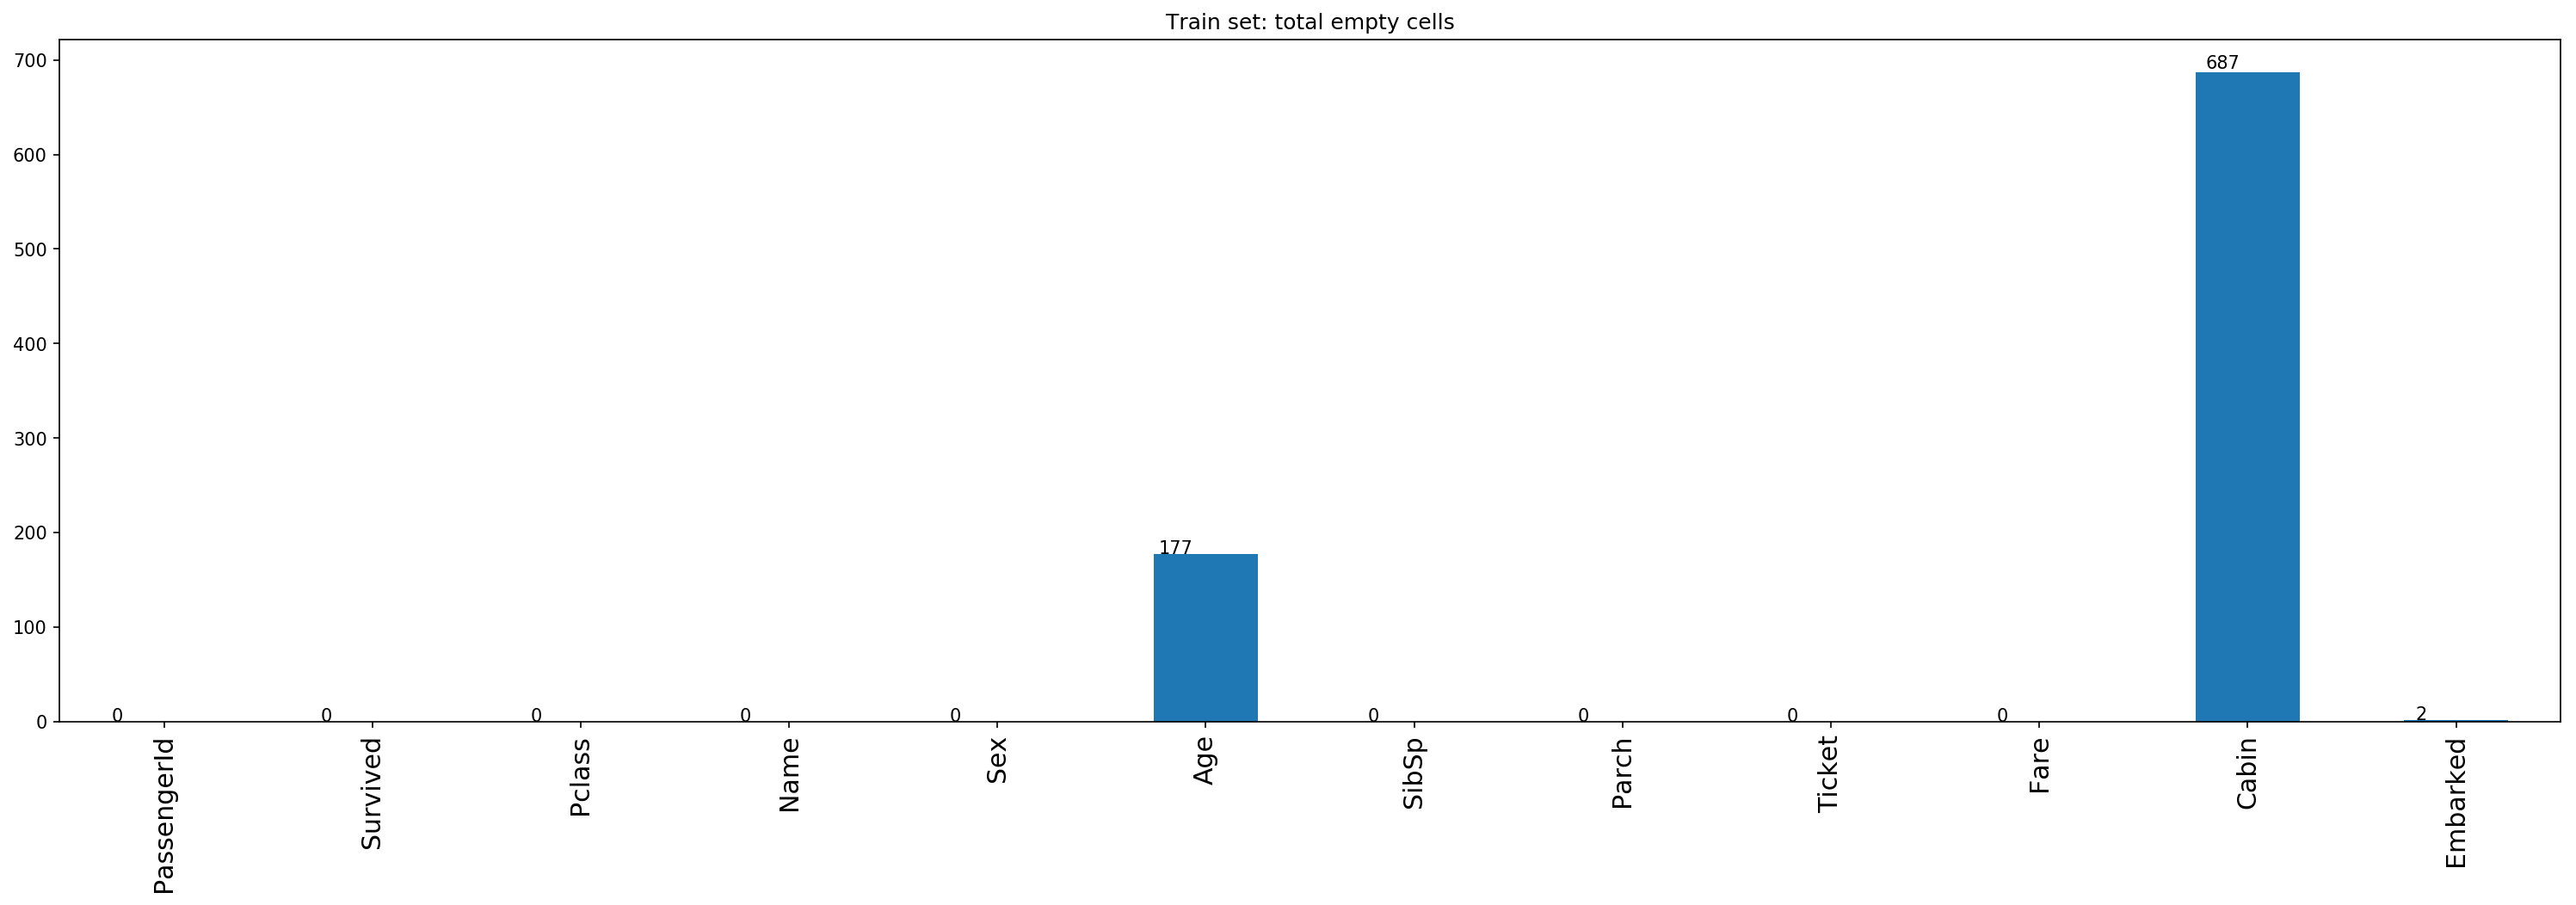

In [6]:
ax = args.raw_train.isna().sum().plot(kind='bar', figsize=(25, 7), stacked=True, title='Train set: total empty cells')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

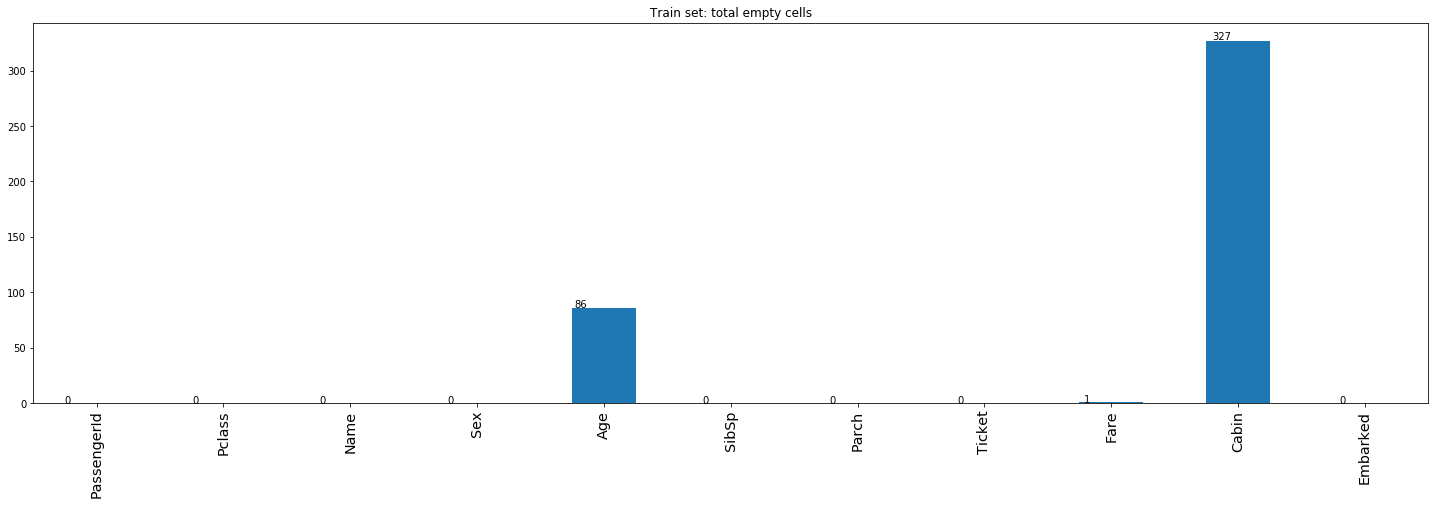

In [18]:
ax = args.raw_test.isna().sum().plot(kind='bar', figsize=(25, 7), stacked=True, title='Train set: total empty cells')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

## Feature engineering

In [19]:
X = args.raw_train.copy().drop('Survived', axis=1)
y = args.raw_train.copy()['Survived']
X_test = args.raw_test.copy()

In [21]:
import numpy as np
from sklearn.pipeline import make_union, Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from functools import reduce
import re

class NameToTitleTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        names = X.to_numpy().reshape(len(X),)
    
        title_dictionary = {
            "Capt": "Officer",
            "Col": "Officer",
            "Major": "Officer",
            "Jonkheer": "Royalty",
            "Don": "Royalty",
            "Sir": "Royalty",
            "Dr": "Officer",
            "Rev": "Officer",
            "the Countess": "Royalty",
            "Mme": "Mrs",
            "Mlle": "Miss",
            "Ms": "Mrs",
            "Mr": "Mr",
            "Mrs": "Mrs",
            "Miss": "Miss",
            "Master": "Master",
            "Lady": "Royalty"
        }
        titles = [fullname.split(',')[1].split('.')[0].strip() for fullname in names]
        short_titles = [title_dictionary.get(title, "Royalty") for title in titles]
        return np.array(short_titles).reshape(len(short_titles), 1)

class SibspParchToFamilySizeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        def _categorize_family_size(family_size_row):
            s_size = 0
            m_size = 4
            family_size = reduce(lambda x, y:x+y, family_size_row)
            if family_size == s_size:
                return 's'
            elif family_size <= m_size:
                return 'm'
            else:
                return 'l'
        family_size_categories = list(map(_categorize_family_size, np.asarray(X.to_numpy())))
        return np.array(family_size_categories).reshape(len(family_size_categories), 1)

class TicketTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        def _clean_ticket(ticket):
            # replace all special chars
            ticket = re.sub('[^a-zA-Z0-9]', '', ticket)
            if ticket[0].isdigit():
                return 'digit'
            return ticket[0]
        ticket_categories = list(map(_clean_ticket, np.asarray(X.to_numpy().reshape(len(X),))))
        return np.array(ticket_categories).reshape(len(ticket_categories), 1)
    


pclass_pipeline = OneHotEncoder(categories='auto')
name_pipeline = make_pipeline(NameToTitleTransformer(), OneHotEncoder(categories='auto'))
sex_pipeline = OrdinalEncoder(dtype='int')
age_fare_pipeline = make_pipeline(SimpleImputer(strategy='median'), )
sibsp_parch_pipeline = make_pipeline(SibspParchToFamilySizeTransformer(), OneHotEncoder(categories='auto'))
ticket_pipeline = make_pipeline(TicketTransformer(), OneHotEncoder(categories='auto'))
embarked_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(categories='auto'))

feature_engineering_col_transformer = ColumnTransformer(
    [('pclass_transformer', pclass_pipeline, ['Pclass']),
     ('name_transformer', name_pipeline, ['Name']),
     ('sex_transformer', sex_pipeline, ['Sex']),
     ('age_fare_transformer', age_fare_pipeline, ['Age', 'Fare']),
     ('sibsp_parch_transformer', sibsp_parch_pipeline, ['SibSp', 'Parch']),
     ('ticket_transformer', ticket_pipeline, ['Ticket']),
     ('embarked_transformer', embarked_pipeline, ['Embarked'])], 
    remainder='drop'
)

print("X_pipeline transformed shape:", feature_engineering_col_transformer.fit_transform(X).shape)

X_pipeline transformed shape: (891, 26)


## Pipeline

In [23]:
def csv_predictions(predictions, filename):
    submission = pd.DataFrame({'PassengerId': args.raw_test['PassengerId'],'Survived': predictions})

    submission.to_csv(filename, index=False)
    print('Saved file: ' + filename)

In [24]:
from sklearn.ensemble import ExtraTreesClassifier

pipeline_clf = ExtraTreesClassifier(random_state=args.seed, n_jobs=-1, 
                                    **{'max_depth': 20, 'max_features': 11, 'min_samples_leaf': 7, 'n_estimators': 10})

titanic_pipeline = Pipeline(
    steps=[
        ('feature-engineering', feature_engineering_col_transformer),
        ('clf', pipeline_clf)
    ]
)

titanic_pipeline.fit(X, y)
predictions_pipeline = titanic_pipeline.predict(X_test).astype(int)
csv_predictions(predictions_pipeline, '../predictions/titanic-pipeline-extra-trees.csv')

Saved file: ../predictions/titanic-pipeline-extra-trees.csv


#### Test score pipeline

|  Model | Params | Test score |
|---|---|---|
| Extra trees | 'max_depth': 20, 'max_features': 11, 'min_samples_leaf': 7, 'n_estimators': 10 |  0.78468 |